In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:

# Funkcja do aproksymacji
Fun = lambda x: np.sin(2 * x[0, :] + x[1, :]) / np.exp(0.2 * x[1, :])

n_inputs = 2 # liczba wejść
n_samples = 10000 # liczba próbek
n_hidden = 500 # liczba neuronów w warstwie ukrytej

# Generowanie losowych próbek wejściowych
X_min = 0; X_max = 10
X = np.random.uniform(X_min, X_max, (n_inputs, n_samples))
Y = Fun(X)

# Przeskalowanie wejść do zakresu [0, 1]
X = (X - X_min) / (X_max - X_min)

# losowy podział danych na uczące i walidujące - 80% uczące, 20% walidujące
n_train = int(0.8 * n_samples)
perm_idx = np.random.permutation(n_samples)

train_idx = perm_idx[:n_train]
val_idx = perm_idx[n_train:]

X_train = X[:, train_idx]
Y_train = Y[train_idx]

X_val = X[:, val_idx]
Y_val = Y[val_idx]


In [37]:

continue_learning = True  # ustaw na True, aby kontynuować uczenie z zapisanymi wagami

if continue_learning:
    # Wczytaj zapisane wagi modelu oraz poprzednie kierunki minimalizacji
    data = np.load("MLP_model_weights.npz")

    W1 = data['W1']
    B1 = data['B1']
    W2 = data['W2']
    b2 = data['b2']
    
    p_b2_old = data['p_b2_old']
    p_W2_old = data['p_W2_old']
    p_b1_old = data['p_b1_old']
    p_W1_old = data['p_W1_old']

else:
    # losowa inicjalizacja wag i biasów
    B1 = np.random.uniform(-1, 1, (n_hidden, 1))
    W1 = np.random.uniform(-1, 1, (n_hidden, n_inputs))
    b2 = np.random.uniform(-1, 1, (1, 1))
    W2 = np.random.uniform(-1, 1, (1, n_hidden))

    # zerowa inicjalizacja poprzedniego kierunku minimalizacji
    p_b2_old = np.zeros((1, 1))
    p_W2_old = np.zeros((1, n_hidden))
    p_b1_old = np.zeros((n_hidden, 1))
    p_W1_old = np.zeros((n_hidden, n_inputs))


Epoka [1/3000]
 MSE train:  1.829525e-03
 MSE val:    1.984183e-03
Epoka [2/3000]
 MSE train:  1.379159e-03
 MSE val:    1.488914e-03
Epoka [3/3000]
 MSE train:  1.460813e-03
 MSE val:    1.570523e-03
Epoka [4/3000]
 MSE train:  1.395266e-03
 MSE val:    1.518067e-03
Epoka [5/3000]
 MSE train:  2.004111e-03
 MSE val:    2.255734e-03
Epoka [6/3000]
 MSE train:  1.961931e-03
 MSE val:    2.227335e-03
Epoka [7/3000]
 MSE train:  1.785428e-03
 MSE val:    1.860138e-03
Epoka [8/3000]
 MSE train:  1.437311e-03
 MSE val:    1.661023e-03
Epoka [9/3000]
 MSE train:  1.420843e-03
 MSE val:    1.567160e-03
Epoka [10/3000]
 MSE train:  1.491812e-03
 MSE val:    1.803822e-03
Epoka [11/3000]
 MSE train:  1.263394e-03
 MSE val:    1.499615e-03
Epoka [12/3000]
 MSE train:  1.262466e-03
 MSE val:    1.446600e-03
Epoka [13/3000]
 MSE train:  2.105531e-03
 MSE val:    2.195539e-03
Epoka [14/3000]
 MSE train:  1.370925e-03
 MSE val:    1.478378e-03
Epoka [15/3000]
 MSE train:  1.504492e-03
 MSE val:    1.

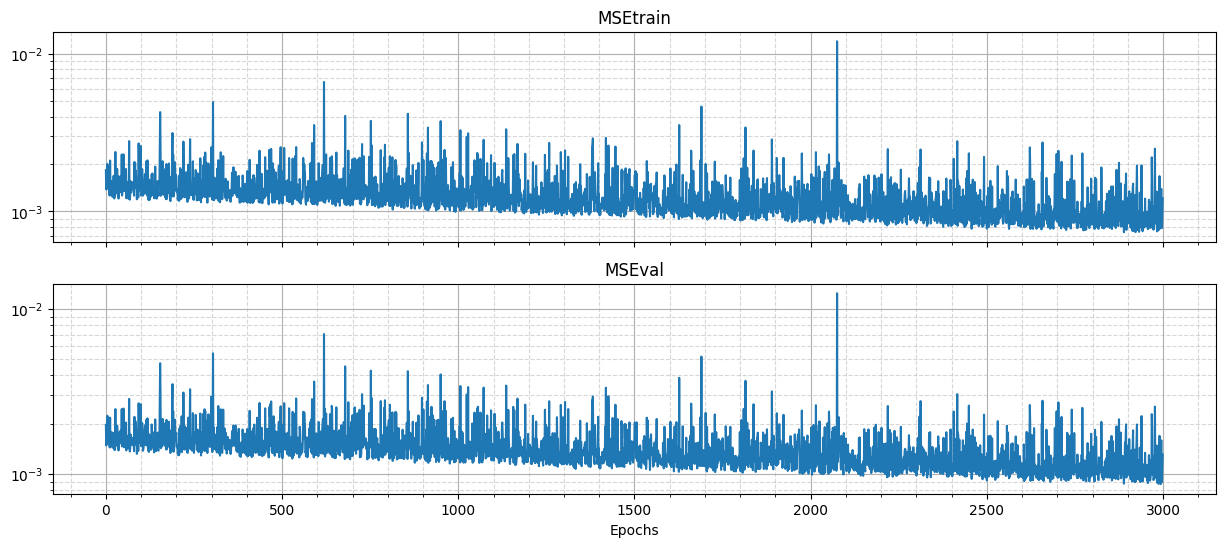

In [34]:

max_epochs = 3000 # maksymalna liczba epok
learning_rate = 0.01 # współczynnik uczenia
momentum = 0.9 # współczynnik momentum
mb_size = 10 # rozmiar mini-batcha


# deklaracja potrzebnych tablic

mb_idx = np.zeros((1, n_train))
Xmb = np.zeros((n_inputs, mb_size))
Ymb = np.zeros((1, mb_size))

Zmb = np.zeros((n_hidden, mb_size))
Vmb = np.zeros((n_hidden, mb_size))
Yhat_mb = np.zeros((1, mb_size))
Emb = np.zeros((1, mb_size))
MSEmb = np.zeros((1,1))

tmp = np.zeros((n_hidden, mb_size))

dE_db2 = np.zeros((1, 1))
dE_dW2 = np.zeros((1, n_hidden))
dE_db1 = np.zeros((n_hidden, 1))
dE_dW1 = np.zeros((n_hidden, n_inputs))

p_b2 = np.zeros((1, 1))
p_W2 = np.zeros((1, n_hidden))
p_b1 = np.zeros((n_hidden, 1))
p_W1 = np.zeros((n_hidden, n_inputs))

p_b2_old = np.zeros((1, 1))
p_W2_old = np.zeros((1, n_hidden))
p_b1_old = np.zeros((n_hidden, 1))
p_W1_old = np.zeros((n_hidden, n_inputs))

MSEtrainTab = np.zeros((max_epochs, 1))
MSEvalTab = np.zeros((max_epochs, 1))


# uczenie sieci metodą SGD z momentum
for i in range(max_epochs):
    for j in range(100):
        mb_idx = np.random.permutation(n_train)[:mb_size]
        Xmb = X_train[:, mb_idx]
        Ymb = Y_train[mb_idx]

        Zmb = W1 @ Xmb + B1
        Vmb = np.maximum(0, Zmb)  # ReLU
        Yhat_mb = W2 @ Vmb + b2
        Emb = Yhat_mb - Ymb
        MSEmb = np.mean(Emb * Emb)

        tmp = (W2.T @ Emb) * np.where(Zmb > 0, 1, 0)  # pochodna ReLU

        dE_db2 = 2 * np.mean(Emb, axis=1)
        dE_dW2 = 2 * (Emb @ Vmb.T) / mb_size
        dE_db1 = 2 * np.mean(tmp, axis=1, keepdims=True)
        dE_dW1 = 2 * (tmp @ Xmb.T) / mb_size

        p_b2 = (1 - momentum) * dE_db2 + momentum * p_b2_old
        p_W2 = (1 - momentum) * dE_dW2 + momentum * p_W2_old
        p_b1 = (1 - momentum) * dE_db1 + momentum * p_b1_old
        p_W1 = (1 - momentum) * dE_dW1 + momentum * p_W1_old

        b2 -= learning_rate * p_b2
        W2 -= learning_rate * p_W2
        B1 -= learning_rate * p_b1
        W1 -= learning_rate * p_W1

        p_b2_old = p_b2
        p_W2_old = p_W2
        p_b1_old = p_b1
        p_W1_old = p_W1

    MSEtrain = np.mean((W2 @ np.maximum(0, W1 @ X_train + B1) + b2 - Y_train) ** 2)
    MSEval = np.mean((W2 @ np.maximum(0, W1 @ X_val + B1) + b2 - Y_val) ** 2)
    print(f"Epoka [{i+1}/{max_epochs}]\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

    MSEtrainTab[i] = MSEtrain
    MSEvalTab[i] = MSEval


# Wyświetlanie przebiegu uczenia

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax1.plot(MSEtrainTab)
ax1.set_yscale('log')
ax1.set_title("MSEtrain")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.plot(MSEvalTab)
ax2.set_yscale('log')
ax2.set_title("MSEval")
ax2.set_xlabel("Epochs")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych


 MSE train:  1.796206e-04
 MSE val:    1.871730e-04

 AbsErr train:  1.012336e-02
 AbsErr val:    1.026147e-02


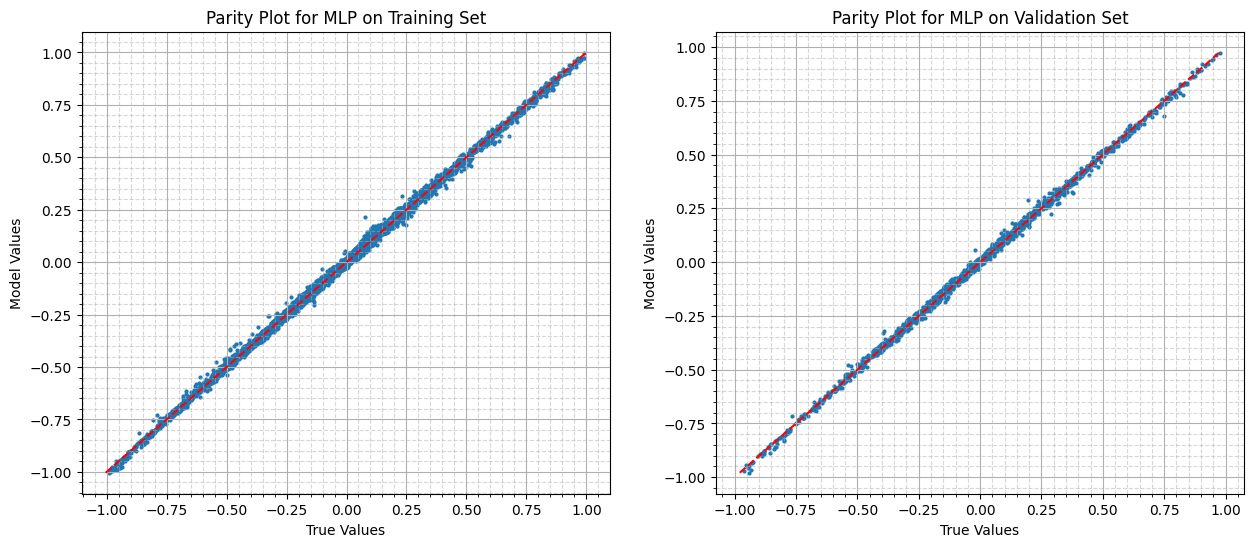

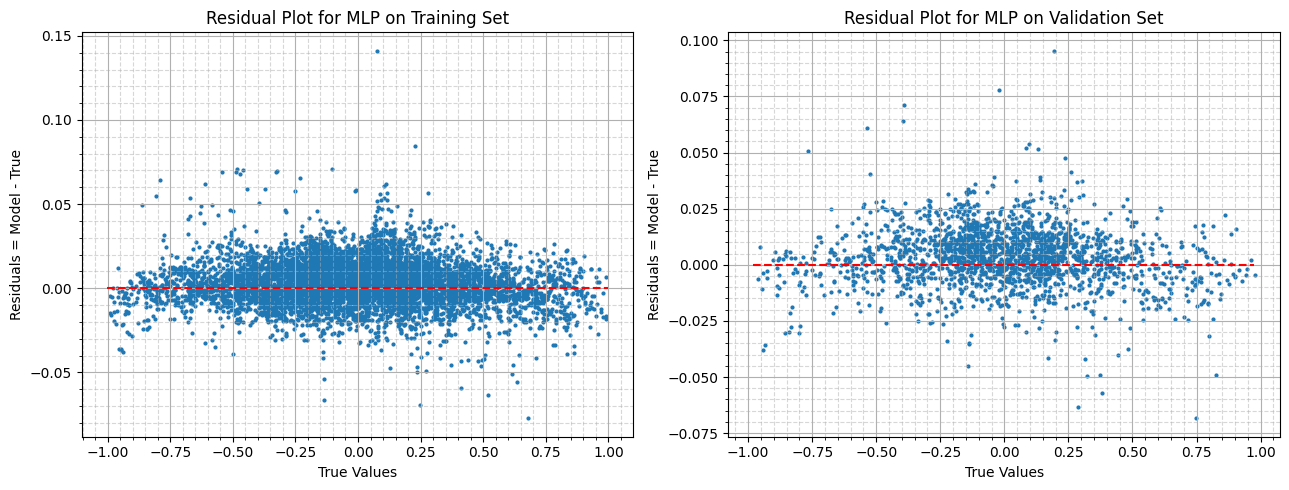

In [38]:

# --- Ocena modelu przed douczeniem ---

Ymodel_train = W2 @ np.maximum(0, W1 @ X_train + B1) + b2
Ymodel_val = W2 @ np.maximum(0, W1 @ X_val + B1) + b2

MSEtrain = np.mean((Ymodel_train - Y_train) ** 2)
MSEval = np.mean((Ymodel_val - Y_val) ** 2)
print(f"\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

ERRtrain = np.mean(np.abs(Ymodel_train - Y_train))
ERRval = np.mean(np.abs(Ymodel_val - Y_val))
print(f"\n AbsErr train:  {ERRtrain:.6e}\n AbsErr val:    {ERRval:.6e}")

#  --- Wykres dopasowania (prawdziwy Y) vs (przewidywany Y) ---

Ymodel_train_min = np.min(Ymodel_train)
Ymodel_train_max = np.max(Ymodel_train)
Ymodel_val_min = np.min(Ymodel_val)
Ymodel_val_max = np.max(Ymodel_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(Y_train, Ymodel_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [Ymodel_train_min, Ymodel_train_max], 'r--')
ax1.set_title("Parity Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Model Values")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [Ymodel_val_min, Ymodel_val_max], 'r--')
ax2.set_title("Parity Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Model Values")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

# --- Wykres residual plot ---

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(Y_train, Ymodel_train - Y_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [0,0], 'r--')
ax1.set_title("Residual Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Residuals = Model - True")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val - Y_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [0,0], 'r--')
ax2.set_title("Residual Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals = Model - True")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy


In [ ]:

save_model = False  # ustaw na True, aby zapisać

if save_model:
    # Zapisz wagi modelu oraz poprzedni kierunek minimalizacji
    # Plik można później wczytać i kontynuować uczenie
    np.savez("MLP_model_weights.npz", 
        W1=W1, B1=B1, W2=W2, b2=b2,
        p_b2_old=p_b2_old, p_W2_old=p_W2_old, p_b1_old=p_b1_old, p_W1_old=p_W1_old)



 MSE train:  1.166366e-04
 MSE val:    1.267716e-04

 AbsErr train:  8.021103e-03
 AbsErr val:    8.439964e-03


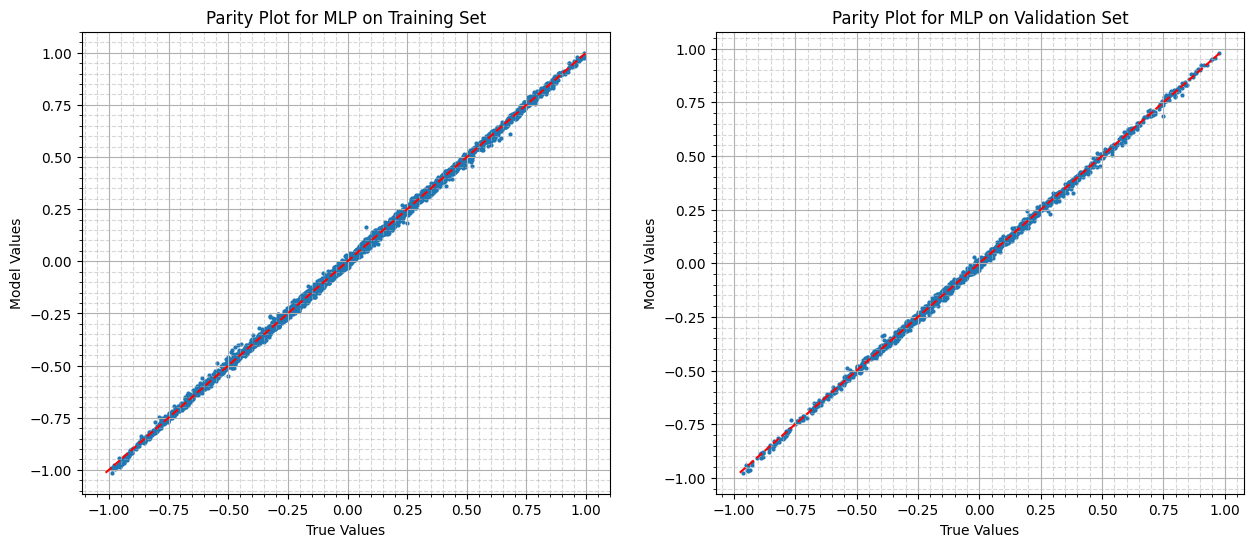

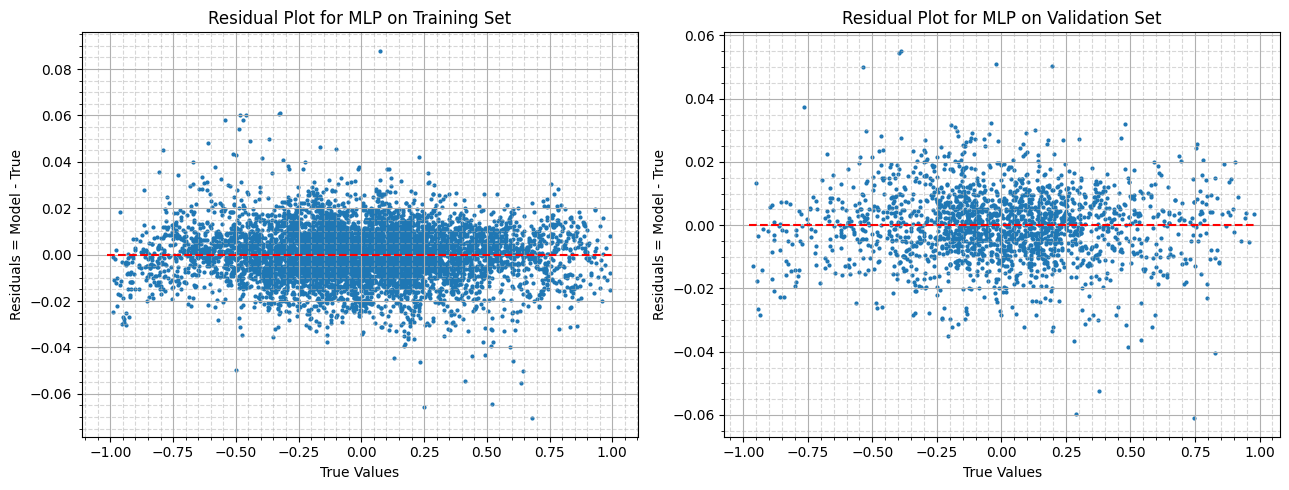

In [39]:

# --- Douczenie wag drugiej warstwy metodą najmniejszych kwadratów ---

lambda_reg = 0.0001  # współczynnik regularizacji

A = np.hstack(( np.ones((n_train, 1)), np.maximum(0, B1 + W1 @ X_train).T ))
W = np.linalg.solve(A.T @ A + lambda_reg * np.eye(n_hidden + 1), A.T @ Y_train)

b2_ = W[0]
W2_ = W[1:].reshape(1, n_hidden)


# --- Ocena modelu po douczeniu ---

Ymodel_train = W2_ @ np.maximum(0, W1 @ X_train + B1) + b2_
Ymodel_val = W2_ @ np.maximum(0, W1 @ X_val + B1) + b2_

MSEtrain = np.mean((Ymodel_train - Y_train) ** 2)
MSEval = np.mean((Ymodel_val - Y_val) ** 2)
print(f"\n MSE train:  {MSEtrain:.6e}\n MSE val:    {MSEval:.6e}")

ERRtrain = np.mean(np.abs(Ymodel_train - Y_train))
ERRval = np.mean(np.abs(Ymodel_val - Y_val))
print(f"\n AbsErr train:  {ERRtrain:.6e}\n AbsErr val:    {ERRval:.6e}")


#  --- Wykres dopasowania (prawdziwy Y) vs (przewidywany Y) ---

Ymodel_train_min = np.min(Ymodel_train)
Ymodel_train_max = np.max(Ymodel_train)
Ymodel_val_min = np.min(Ymodel_val)
Ymodel_val_max = np.max(Ymodel_val)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(Y_train, Ymodel_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [Ymodel_train_min, Ymodel_train_max], 'r--')
ax1.set_title("Parity Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Model Values")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [Ymodel_val_min, Ymodel_val_max], 'r--')
ax2.set_title("Parity Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Model Values")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

# --- Wykres residual plot ---

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(Y_train, Ymodel_train - Y_train, s=4)
ax1.plot([Ymodel_train_min, Ymodel_train_max], [0,0], 'r--')
ax1.set_title("Residual Plot for MLP on Training Set")
ax1.set_xlabel("True Values")
ax1.set_ylabel("Residuals = Model - True")
ax1.minorticks_on()  # włącza dodatkowe podziałki
ax1.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax1.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

ax2.scatter(Y_val, Ymodel_val - Y_val, s=4)
ax2.plot([Ymodel_val_min, Ymodel_val_max], [0,0], 'r--')
ax2.set_title("Residual Plot for MLP on Validation Set")
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals = Model - True")
ax2.minorticks_on()  # włącza dodatkowe podziałki
ax2.grid(True, which='major', linestyle='-')   # grubsze linie dla głównych
ax2.grid(True, which='minor', linestyle='--', alpha=0.5)   # cieńsze dla pomocniczych

plt.tight_layout() # ładniej wyglądają wykresy
